### Проект выполнил
Ф.И.О Мирошкин Ярослав Андреевич <br>
Telegram - https://t.me/MiroshkinYaroslav

## Описание проекта
Необходимо на основе имеющихся размеченных субтитров на английском языке автоматизировать процесс подбора фильма по заданному уровню английского языка.   

## Тип задачи
* Обработка естественного языка
* Обучение с учителем
* Ранжирование

## Цели
* Разработать модель машинного обучения позволяющую предсказать необходимый уровень английского языка для просмотра фильма 

## Описание данных
* Субтитры на английском языке разного (известного) уровня сложности. От A1+ (elementary) до C1 (Advanced). 

# English Score


In [1]:
import os
import pysrt as srt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pickle
import optuna
import pprint
import re
import torch
import tensorflow as tf
import warnings


import lightgbm as lgb

import nltk
from nltk.corpus import stopwords

from catboost import CatBoostClassifier, Pool

from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer,
    precision_recall_fscore_support,
    accuracy_score,
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (RandomizedSearchCV,
GridSearchCV)
from sklearn.neighbors import  KNeighborsClassifier

from transformers import TFAutoModel, AutoTokenizer

from datasets import load_dataset


warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')

STATE = 0
N_FOLDS = 3

c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(cm)
    cmp.plot()


In [3]:
def my_bar(data: pd.Series, dropna=True, title='', xlabel='', ylabel=''):
    distribution = data.value_counts(dropna=dropna, normalize=False)
    distribution_normalized = data.value_counts(dropna=dropna, normalize=True)
    _, ax = plt.subplots(1)
    sns.barplot(x=distribution_normalized.index, y=distribution_normalized.values).set(
    title=title, xlabel=xlabel, ylabel=ylabel)
    for a, p in enumerate(ax.patches):
        text = str(distribution.iloc[a])
        ax.annotate(text, xy=(p.get_x() + p.get_width() / 2, 0.8 * p.get_height()), \
        size=13, color='black', ha = 'center', va = 'center',
        bbox = dict(boxstyle = 'round',\
        facecolor='none',edgecolor='black', alpha = 0.5) )

def my_kde(df: pd.DataFrame(), col=''):
    f, (ax_kde, ax_box) = plt.subplots(2, gridspec_kw={"height_ratios": (0.85, 0.15)}, sharex=True)
    sns.kdeplot(df, alpha=0.3, fill=True, color='green', ax=ax_kde)
    ax_kde.set(xlabel='', yticks=[])
    ax_kde.set_title(col, fontsize=16)
    sns.boxplot(data=df, orient='h', ax=ax_box, color='green')
    plt.subplots_adjust(hspace=0)
    ax_box.set_xlabel('')

def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun, return_delta=False):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    metric_train = metric_fun(y_train, y_pred_train, average='macro')
    metric_test = metric_fun(y_test, y_pred_test, average='macro')
    if return_delta:
        return round((abs(metric_train - metric_test)/metric_train*100), 2)
    else:
        print(f'{metric_fun.__name__} train: %.3f' % metric_train)
        print(f'{metric_fun.__name__} test: %.3f' % metric_test)
        print(f'delta = {(abs(metric_train - metric_test)/metric_train*100):.1f} %')
    
def get_metrics(y_true, y_pred, name='None', metrics=None):
    presision, recall, f1, sup = precision_recall_fscore_support(y_test, 
                            y_pred)
    presision, recall, f1 = presision.mean(), recall.mean(), f1.mean()
    result = pd.DataFrame(data={'precision': presision,
                                'recall': recall,
                                'f1_score': f1,
                                'accuracy': accuracy_score(y_true, y_pred)}, 
                                index=[name]).round(2)
    if metrics is None:
        return result
    else:
        return pd.concat([metrics, result], axis=0)

## Чтение данных

In [4]:
movies_labels = pd.read_excel('english_scores\movies_labels.xlsx', index_col='Movie').drop('id', axis=1)
paths = ['english_scores/subtitles_all/subtitles/',
         'english_scores/subtitles_all/A2/',
         'english_scores/subtitles_all/B1/',
         'english_scores/subtitles_all/B2/',
         'english_scores/subtitles_all/C1/',
         'subtitles/']
data = {}
for path in paths:
    for sub_name in os.listdir(path[:-1]):
        try:
            subs = srt.open(path + sub_name, encoding='utf-8')
        except:
            subs = srt.open(path + sub_name, encoding='ISO-8859-1')
        sub_list = " ".join([sub.text for sub in subs])
        data[sub_name[:-4]] = sub_list


In [5]:
df = pd.DataFrame(data.values(), index=data.keys(), columns=['subtitle'])
df.head(3)

,subtitle
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz..."
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here..."
Aladdin(1992),"<i>Oh, I come from a land\nFrom a faraway plac..."


Получен датасет, где:<br>
индексы - названия фильмов<br>
subtitle - субтитры в строков формате <br><br>
Оценим общее количество символов в "сыром датасете"

In [6]:
print(f'Общее количество символов в субтитрах: {df.subtitle.str.len().sum():,.0f}')

Общее количество символов в субтитрах: 11,277,626


## Добавление и обработка разметки

Добавим в датасет разметку

In [7]:
movies_labels.head(3)

,Level
Movie,
10_Cloverfield_lane(2016),B1
10_things_I_hate_about_you(1999),B1
A_knights_tale(2001),B2


In [8]:
print(f'Количество файлов субтитров: {df.subtitle.count()}\n\
Количество строк в разметке: {movies_labels.Level.count()}')

Количество файлов субтитров: 279
Количество строк в разметке: 241


Часть данных не размечена

In [9]:
df = df.join(movies_labels)
df = df.rename(columns={'Level': 'level'})
df.head(2)

,subtitle,level
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz...",B1
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here...",B1


Проанализируем баланс классов в `level`

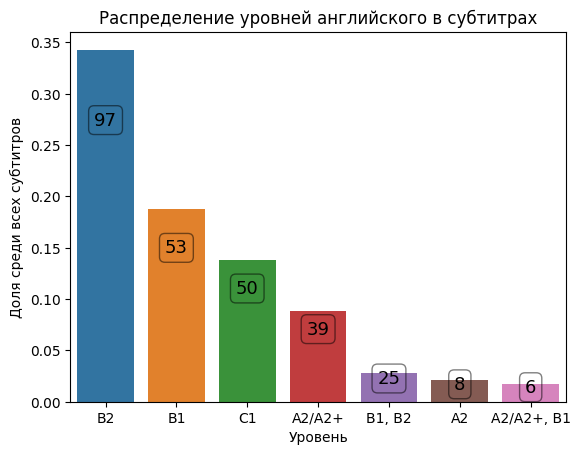

In [10]:
my_bar(df.level, dropna=False, title='Распределение уровней английского в субтитрах',\
        xlabel='Уровень', ylabel='Доля среди всех субтитров')

Оставим 4 основных уровня знания языка:
* A2, A2+ - Beginner, Elementary 
* B1 - Intermediate 
* B2 - Upper-Intermediate 
* C1 - Advanced


In [11]:
df = df.replace({'level' :{'B1, B2': 'B1',
                      'A2': 'A2/A2+',
                      'A2/A2+, B1': 'A2/A2+'}})

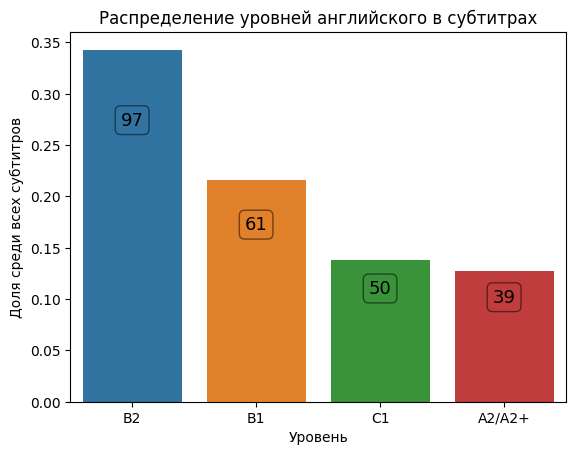

In [12]:
my_bar(df.level, dropna=False, title='Распределение уровней английского в субтитрах',\
        xlabel='Уровень', ylabel='Доля среди всех субтитров')

In [13]:
english_levels = ['A2/A2+', 'B1', 'B2', 'C1']

Присутствует дисбаланс классов <br><br>
Удалим неразмеченные данные

In [14]:
df = df.dropna(subset='level', axis=0)

Заменим уровни знания языка числовыми параметрами в порядке возрастания.
* A2, A2+ - 0
* B1 - 1
* B2 - 2 
* C1 - 3

In [15]:
df.level = df.level.replace({'A2/A2+': 0,
                  'B1': 1,
                  'B2': 2,
                  'C1': 3})

## Обработка данных

#### Приведение к нижнему регистру, обработка спецсимволов и "стоп-слов"

In [16]:
# Пример "стоп-слов"
np.array(stopwords.words('english'))[:20]

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his'], dtype='<U10')

In [17]:
def preprocess_text(data, stopwords=stopwords.words('english')):
    #Приводим к нижему регистру
    text = data.lower()
    #Удаляем все символы между <>, '<some symbols>' -> ''
    text = re.sub('<[^>]+>', '', text)
    #Добавляем пробелы между знаками препинания
    text = re.sub(r"([.,!?])", r" \1 ", text)
    # удаляем пробелы в начале и в конце предложения
    text = text.strip()
    #Удаляем слова в скобках
    text = re.sub(r'\([^)]*\)', '', text)
    # Оставляем только латинские буквы
    text = re.sub(r'[^a-z]', ' ', text)
    # удаление стоп-слов
    text = [w for w in text.split() if w not in stopwords]
    # удаляем слова короче 3х символов
    text = [w for w in text if len(w) >= 3]
    return ' '.join(text)

In [18]:
df.subtitle = df.subtitle.apply(lambda text: preprocess_text(text))

#### Стемминг и лемматизация

In [19]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [20]:
flag = 1
if flag:
    df['lemma_clear_text'] = df.subtitle.apply(lambda row: lemmatize(row))
    with open('df_lemma.pickle', 'wb') as file:
        pickle.dump(df, file)
else:
    with open('df_lemma.pickle', 'rb') as file:
        df = pickle.load(file)

In [21]:
df = df.loc[~(df.lemma_clear_text=='')]

In [22]:
features = df.lemma_clear_text
target = df.level

In [23]:
X_train, X_test, y_train, y_test = \
    train_test_split(features, target,
         test_size=0.25, random_state=STATE, shuffle=True)

### Оценка количества слов в субтитрах

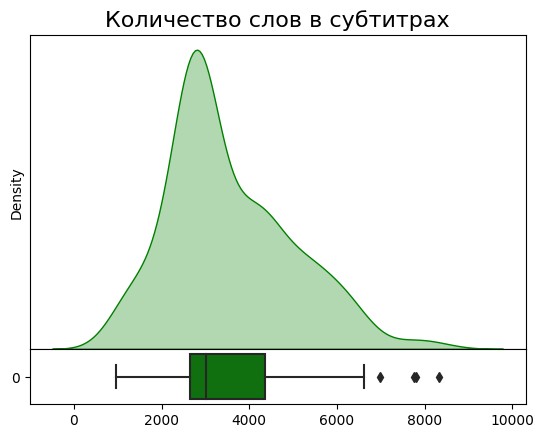

In [24]:
my_kde(df.lemma_clear_text.apply(lambda x: len(x.split())), 
       col='Количество слов в субтитрах')

###  Наиболее популярные слова

Найдем 2000 наиболее популярных слов в фильмах различного уровня знания английского языка

In [25]:
most_popular_words = {}
HOW_MANY_WORDS = 2000
for level in range(0, 3 + 1):
    count_words = CountVectorizer()
    bag = count_words.fit_transform(
        df.loc[df.level==level].lemma_clear_text.values)
    most_popular_words[level] = \
        list(pd.DataFrame.sparse.from_spmatrix(bag, 
                        columns=count_words.get_feature_names_out())\
    .sum().sort_values(ascending=False)[:HOW_MANY_WORDS].index)
    

In [26]:
WORDS_TO_SHOW = 25
for level, words in most_popular_words.items():
    print(f'Уровень {english_levels[level]}, {WORDS_TO_SHOW} наиболее популярных слов:\n\
          {words[:WORDS_TO_SHOW]}\n')


Уровень A2/A2+, 25 наиболее популярных слов:
          ['get', 'know', 'come', 'go', 'like', 'right', 'yeah', 'okay', 'well', 'see', 'want', 'think', 'one', 'to', 'say', 'good', 'look', 'hey', 'let', 'man', 'tell', 'take', 'make', 'love', 'time']

Уровень B1, 25 наиболее популярных слов:
          ['get', 'know', 'go', 'come', 'like', 'right', 'well', 'yeah', 'one', 'think', 'look', 'see', 'say', 'okay', 'good', 'want', 'to', 'let', 'make', 'take', 'tell', 'hey', 'yes', 'time', 'man']

Уровень B2, 25 наиболее популярных слов:
          ['get', 'know', 'go', 'want', 'well', 'right', 'tell', 'say', 'come', 'like', 'think', 'one', 'to', 'see', 'yeah', 'make', 'good', 'take', 'need', 'look', 'okay', 'time', 'harvey', 'let', 'thing']

Уровень C1, 25 наиболее популярных слов:
          ['know', 'get', 'go', 'well', 'think', 'want', 'say', 'tell', 'come', 'one', 'right', 'like', 'take', 'see', 'make', 'to', 'would', 'good', 'need', 'look', 'back', 'let', 'thing', 'harvey', 'mean']



Сравним наиболее популярную лексику в представленных фильмах с лексикой  A2/A2+

In [27]:
def set_intersection(set1: set, set2: set) -> float:
    return len(set1 & set2) / len(set1)

set_shares = [set_intersection(
    set(most_popular_words[0]), set(most_popular_words[i])
    ) for i in range(0,3+1)]

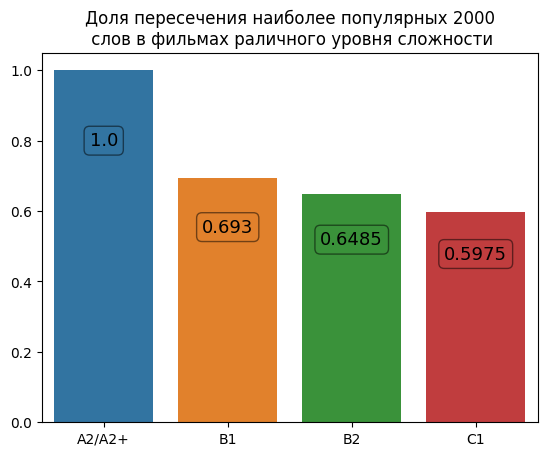

In [28]:
_, ax = plt.subplots(1)
sns.barplot(x=english_levels, y=set_shares, ax=ax)\
    .set(title=f'Доля пересечения наиболее популярных {HOW_MANY_WORDS}\n\
 слов в фильмах раличного уровня сложности');
for a, p in enumerate(ax.patches):
        text = set_shares[a]
        ax.annotate(text, xy=(p.get_x() + p.get_width() / 2, 0.8 * p.get_height()), \
        size=13, color='black', ha = 'center', va = 'center',
        bbox = dict(boxstyle = 'round',\
        facecolor='none',edgecolor='black', alpha = 0.5) )

Доля совпадающей лексики снижается, с улучшением знания языка<br>
Проверим, долю совпадающих наиболее популярных слов с рекомендациями учебника  `The_Oxford_by_CEFR_level`

In [29]:
# Считываем слова
with open('oxford/The_Oxford_3000_by_CEFR_level.txt', 'r') as file:
    words = file.read().split()
    a12_words = words[words.index('A1') + 5:words.index('B1')]
    b1_words = words[words.index('B1') + 1:]
with open('oxford/The_Oxford_5000_by_CEFR_level.txt', 'r') as file:
    words = file.read().split()
    b2_words = words[words.index('B2') + 5:words.index('C1')]
    c1_words = words[words.index('C1') + 1:]
with open('oxford\American_Oxford_3000_by_CEFR_level.txt', 'r') as file:
    words = file.read().split()
    a12_words_american = words[words.index('A1') + 5:words.index('B1')]
    b1_words_american = words[words.index('B1') + 1:]
with open('oxford\American_Oxford_5000_by_CEFR_level.txt', 'r') as file:
    words = file.read().split()
    b2_words_american = words[words.index('B2') + 5:words.index('C1')]
    c1_words_american = words[words.index('C1') + 1:]


In [30]:
# Удаляем лишнее
my_stop_words = ['indefinite', 'article', 'modal']
def prepare_words(words: list) -> list:
    words = [w for w in words if '.' not in w]
    words = [w for w in words if len(w) >= 3]
    words = [w for w in words if w not in my_stop_words]
    return words
oxford_words = list(map(prepare_words, [a12_words,\
                                    b1_words, b2_words, c1_words]))
oxford_words_american = list(map(prepare_words, [a12_words_american,\
                                    b1_words_american, b2_words_american, c1_words_american]))

In [31]:
def make_heatmap(words: list, most_popular_words: list, american=False) -> pd.DataFrame:
    pop_words_intersection =np.empty((len(words),
                                   len(most_popular_words)))
    for i in range(0, 3 + 1):
        for j in range(0, 3 + 1):
            pop_words_intersection[i][j] = (set_intersection(
                        set(words[i]),
                        set(most_popular_words[j][:len(words[i])])
    )
            )
    if not american:
        text = 'oxford '
    else:
        text = 'am_oxford '
    pop_words_intersection = pd.DataFrame(pop_words_intersection, 
                index=[text + x  for x in english_levels],
                columns=['films ' + x  for x in english_levels])
    return pop_words_intersection

In [32]:
pop_oxford_intersection = make_heatmap(oxford_words, most_popular_words)
pop_oxford_american_intersection = make_heatmap(oxford_words_american, most_popular_words, american=True)

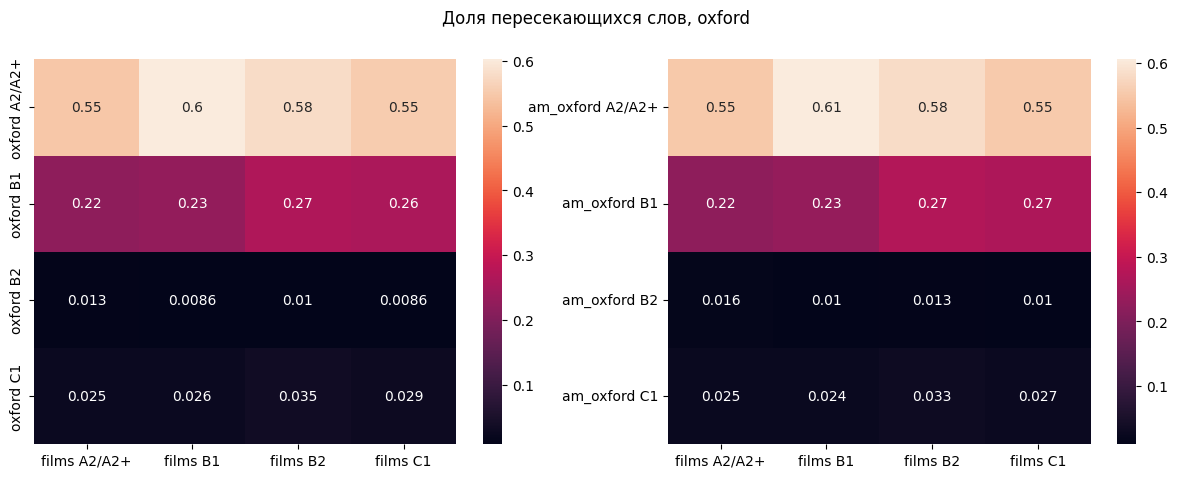

In [33]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
f.suptitle('Доля пересекающихся слов, oxford')
sns.heatmap(pop_oxford_intersection, annot=True, ax=ax[0]);
sns.heatmap(pop_oxford_american_intersection, annot=True, ax=ax[1]);

In [34]:
len(oxford_words[2]) + \
len(oxford_words[3]) 

2028

Анализ полученных тепловых карт показывает:
1. Наиболее популярные слова действительно проходят при изучении английского уровня `A1/A1+`. Выучив язык на этом уровне можно расчитывать на понимание порядка 55 % слов в любых фильмах. Придется иметь словарный запас ~ 2000 слов.
2. Дополнительно выучив лексику уровня `B1` понимание при просмотре достигнет почти 80 % в любых фильмах. Словарный запас ~ 3500 слов.
3. Выученная сложная лексика английского языка (дополнительные ~2000 слов) `B2 и C1` рекомендуемая `The_Oxford_by_CEFR_level` не поможет довести уровень понимания фильмов до 100 %. Так как в фильмах встречаются множество сложных слов, не пересекающихся с учебником.
4. Разница для понимания фильмов при изучении "Британского" и "Американского" английского не существенна

### Векторизация

In [35]:
corpus_train = X_train.values
corpus_test = X_test.values

In [36]:
tfidf = TfidfVectorizer()
tf_idf_train = tfidf.fit_transform(corpus_train)
tf_idf_test = tfidf.transform(corpus_test)

### Моделирование

### Dummy model 
Предсказание наиболее популярного класса

In [37]:
print(classification_report(y_test, 2 * np.ones(len(y_test))))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        16
           2       0.45      1.00      0.62        25
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.11      0.25      0.16        55
weighted avg       0.21      0.45      0.28        55



In [38]:
metrics = get_metrics(y_test, 2 * np.ones(len(y_test)), 'dummy_model')
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45


### LogisticRegression Tuning

In [39]:
lr = LogisticRegression(random_state=STATE, class_weight='balanced')
params_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 1.0, 10.0, 100.0]
}
grid_lr = GridSearchCV(estimator=lr, 
                    param_grid=params_lr, 
                    cv=5, 
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

In [40]:
grid_lr.fit(tf_idf_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.01, 1.0, 10.0, 100.0],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

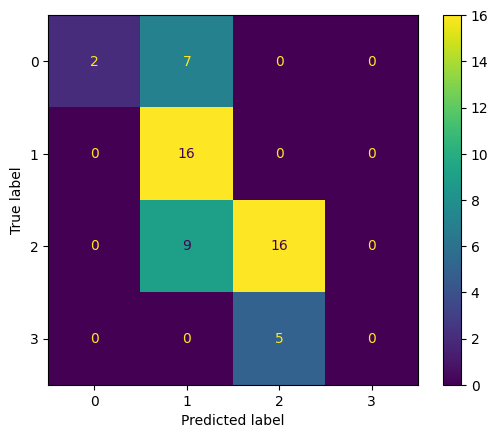

In [41]:
plot_confusion_matrix(y_test, 
                      grid_lr.best_estimator_.predict(tf_idf_test))

In [42]:
print(classification_report(y_test, 
                      grid_lr.best_estimator_.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.50      1.00      0.67        16
           2       0.76      0.64      0.70        25
           3       0.00      0.00      0.00         5

    accuracy                           0.62        55
   macro avg       0.57      0.47      0.43        55
weighted avg       0.66      0.62      0.57        55



In [43]:
metrics = get_metrics(y_test, 
                      grid_lr.best_estimator_.predict(tf_idf_test),
                      name='LogisticRegression', metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45
LogisticRegression,0.57,0.47,0.43,0.62


In [44]:
check_overfitting(grid_lr.best_estimator_, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.938
f1_score test: 0.431
delta = 54.0 %


### RandomForestClassifier Tuning

In [45]:
flag = 1
if flag:
    rfc = RandomForestClassifier(random_state=STATE)
    params_rfc = {
    'max_depth': range(8, 25, 2),
    'n_estimators': range(40, 161, 30),
    'class_weight': ['balanced', 'balanced_subsample'],
    'min_samples_split': range(2,5,1)
    }
    grid_rfc = GridSearchCV(estimator=rfc, 
                            param_grid=params_rfc,
                            n_jobs=-1, 
                            )
    grid_rfc.fit(tf_idf_train, y_train)
    with open('content/grid_rfc.pickle', 'wb') as file:
        pickle.dump(grid_rfc, file)
else:
    with open('content/grid_rfc.pickle', 'rb') as file:
        grid_rfc = pickle.load(file)

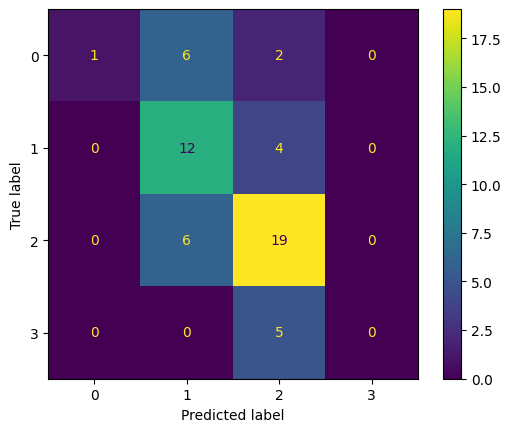

In [46]:
plot_confusion_matrix(y_test, 
                      y_pred=grid_rfc.best_estimator_.predict(tf_idf_test))

In [47]:
print(classification_report(y_test, 
                            y_pred=grid_rfc.best_estimator_.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.50      0.75      0.60        16
           2       0.63      0.76      0.69        25
           3       0.00      0.00      0.00         5

    accuracy                           0.58        55
   macro avg       0.53      0.41      0.37        55
weighted avg       0.60      0.58      0.52        55



In [48]:
metrics = get_metrics(y_test, 
                      grid_rfc.best_estimator_.predict(tf_idf_test),
                      name='RandomForesClassifier', metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45
LogisticRegression,0.57,0.47,0.43,0.62
RandomForesClassifier,0.53,0.41,0.37,0.58


In [49]:
check_overfitting(grid_rfc.best_estimator_, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.993
f1_score test: 0.373
delta = 62.5 %


### LightGBM Tuning

In [50]:
flag = 1
if flag:
    lgb_model = lgb.LGBMClassifier(random_state=STATE, class_weight='balanced')
    params_lgb = {
    'num_leaves': range(40, 120),
    'max_depth': range(4, 13, 2),
    'max_bin': range(20, 51, 10),
    'num_iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1]
    }
    grid_lgb = RandomizedSearchCV(estimator=lgb_model,
                            param_distributions=params_lgb,
                            n_jobs=-1, verbose=2, n_iter=1_000, random_state=STATE
                            )
    grid_lgb.fit(tf_idf_train, y_train)
    with open('content/grid_lgb.pickle', 'wb') as file:
        pickle.dump(grid_lgb, file)
else:
    with open('content/grid_lgb.pickle', 'rb') as file:
        grid_lgb = pickle.load(file)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


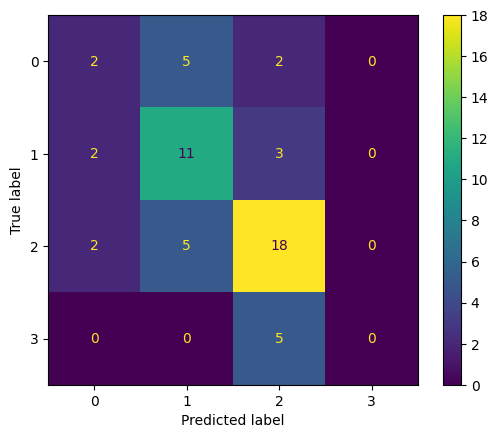

In [51]:
plot_confusion_matrix(y_test, grid_lgb.best_estimator_.predict(tf_idf_test))

In [52]:
print(classification_report(y_test, 
                            grid_lgb.best_estimator_.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.33      0.22      0.27         9
           1       0.52      0.69      0.59        16
           2       0.64      0.72      0.68        25
           3       0.00      0.00      0.00         5

    accuracy                           0.56        55
   macro avg       0.38      0.41      0.39        55
weighted avg       0.50      0.56      0.53        55



In [53]:
metrics = get_metrics(y_test, 
                      grid_lgb.best_estimator_.predict(tf_idf_test),
                      name='LightGBM', metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45
LogisticRegression,0.57,0.47,0.43,0.62
RandomForesClassifier,0.53,0.41,0.37,0.58
LightGBM,0.38,0.41,0.39,0.56


In [54]:
check_overfitting(grid_lgb.best_estimator_, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.993
f1_score test: 0.385
delta = 61.2 %


### CatBoostClassifier `GPU` Baseline

In [55]:
flag = 1
if flag:
    cbc_gpu_baseline = CatBoostClassifier(random_state=STATE,  task_type='GPU',
                                          max_depth=8)
    cbc_gpu_baseline.fit(tf_idf_train, y_train)
    with open('content/cbc_gpu_baseline.pickle', 'wb') as file:
        pickle.dump(cbc_gpu_baseline,file)
else:
    with open('content/cbc_gpu_baseline.pickle', 'rb') as file:
        cbc_gpu_baseline = pickle.load(file)

Learning rate set to 0.044774
0:	learn: 1.3351418	total: 198ms	remaining: 3m 17s
1:	learn: 1.3046475	total: 350ms	remaining: 2m 54s
2:	learn: 1.2649679	total: 472ms	remaining: 2m 36s
3:	learn: 1.2378303	total: 614ms	remaining: 2m 32s
4:	learn: 1.2085573	total: 754ms	remaining: 2m 30s
5:	learn: 1.1863283	total: 905ms	remaining: 2m 29s
6:	learn: 1.1598235	total: 1.05s	remaining: 2m 29s
7:	learn: 1.1304755	total: 1.18s	remaining: 2m 26s
8:	learn: 1.1057464	total: 1.31s	remaining: 2m 24s
9:	learn: 1.0743853	total: 1.45s	remaining: 2m 23s
10:	learn: 1.0481564	total: 1.58s	remaining: 2m 22s
11:	learn: 1.0263576	total: 1.73s	remaining: 2m 22s
12:	learn: 1.0029849	total: 1.86s	remaining: 2m 21s
13:	learn: 0.9790486	total: 2s	remaining: 2m 20s
14:	learn: 0.9618665	total: 2.15s	remaining: 2m 21s
15:	learn: 0.9422921	total: 2.3s	remaining: 2m 21s
16:	learn: 0.9257372	total: 2.44s	remaining: 2m 20s
17:	learn: 0.9062574	total: 2.56s	remaining: 2m 19s
18:	learn: 0.8902122	total: 2.7s	remaining: 2m 1

In [56]:
print(classification_report(y_test, cbc_gpu_baseline.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.56      0.94      0.70        16
           2       0.83      0.80      0.82        25
           3       1.00      0.40      0.57         5

    accuracy                           0.69        55
   macro avg       0.72      0.56      0.57        55
weighted avg       0.71      0.69      0.66        55



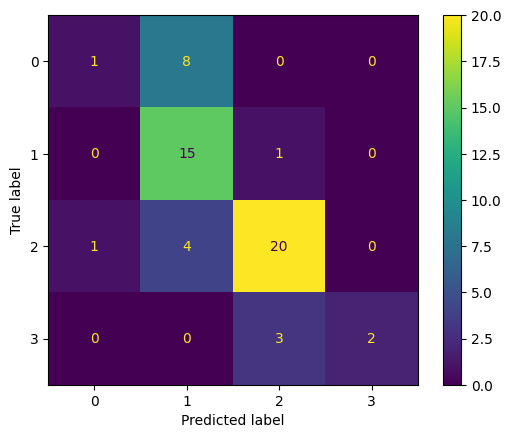

In [57]:
plot_confusion_matrix(y_test, \
                      cbc_gpu_baseline.predict(tf_idf_test))

In [58]:
metrics = get_metrics(y_test, 
                      cbc_gpu_baseline.predict(tf_idf_test),
                      name='Catboost_baseline', metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45
LogisticRegression,0.57,0.47,0.43,0.62
RandomForesClassifier,0.53,0.41,0.37,0.58
LightGBM,0.38,0.41,0.39,0.56
Catboost_baseline,0.72,0.56,0.57,0.69


In [59]:
check_overfitting(cbc_gpu_baseline, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.993
f1_score test: 0.567
delta = 42.9 %


### CatBoostClassifier `GPU` Optuna

In [60]:
def objective(trial, X, y, N_FOLDS, random_state=0):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 8),
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=STATE)
    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        train_data = Pool(data=X_train, label=y_train)
        eval_data = Pool(data=X_test, label=y_test)
        
        model = CatBoostClassifier(**params, task_type='GPU')
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = f1_score(y_test, preds, average='macro')

    return np.mean(cv_predicts[idx])

In [61]:
flag = 1
if flag:
    study_cat = optuna.create_study(direction="maximize", study_name="cbc")
    def func_cat(trial):
        return objective(trial,
                            X=pd.DataFrame.sparse.from_spmatrix(tf_idf_train),
                            y=y_train,
                            N_FOLDS=N_FOLDS,
                            random_state=STATE)
    study_cat.optimize(func_cat, n_trials=5, show_progress_bar=True)
    cbc_gpu_optuna = CatBoostClassifier(**study_cat.best_params,
                                        task_type='GPU', 
                                        random_state=STATE)
    cbc_gpu_optuna.fit(tf_idf_train, y_train)
    with open('content/cbc_optuna.pkl', 'wb') as file:
        pickle.dump(cbc_gpu_optuna, file)
else:
    with open('content/cbc_optuna.pkl', 'rb') as file:
        cbc_gpu_optuna = pickle.load(file)

[I 2023-06-29 17:39:24,237] A new study created in memory with name: cbc
Best trial: 0. Best value: 0.582576:  20%|██        | 1/5 [02:09<08:39, 129.95s/it]

[I 2023-06-29 17:41:34,192] Trial 0 finished with value: 0.5825757575757575 and parameters: {'learning_rate': 0.0018179396551428594, 'depth': 5}. Best is trial 0 with value: 0.5825757575757575.


Best trial: 0. Best value: 0.582576:  40%|████      | 2/5 [03:46<05:30, 110.33s/it]

[I 2023-06-29 17:43:10,784] Trial 1 finished with value: 0.5337365591397849 and parameters: {'learning_rate': 0.0016510463129151658, 'depth': 4}. Best is trial 0 with value: 0.5825757575757575.


Best trial: 2. Best value: 0.59478:  60%|██████    | 3/5 [04:48<02:56, 88.35s/it]  

[I 2023-06-29 17:44:12,984] Trial 2 finished with value: 0.5947802197802198 and parameters: {'learning_rate': 0.06551924087436464, 'depth': 5}. Best is trial 2 with value: 0.5947802197802198.


Best trial: 2. Best value: 0.59478:  80%|████████  | 4/5 [05:48<01:17, 77.07s/it]

[I 2023-06-29 17:45:12,745] Trial 3 finished with value: 0.49492337164750955 and parameters: {'learning_rate': 0.0013391127682410608, 'depth': 2}. Best is trial 2 with value: 0.5947802197802198.


Best trial: 4. Best value: 0.631034: 100%|██████████| 5/5 [06:36<00:00, 79.39s/it]


[I 2023-06-29 17:46:01,206] Trial 4 finished with value: 0.6310344827586207 and parameters: {'learning_rate': 0.009552097999388715, 'depth': 1}. Best is trial 4 with value: 0.6310344827586207.
0:	learn: 1.3794679	total: 26.3ms	remaining: 26.2s
1:	learn: 1.3728098	total: 38.9ms	remaining: 19.4s
2:	learn: 1.3663138	total: 51.8ms	remaining: 17.2s
3:	learn: 1.3599741	total: 64.3ms	remaining: 16s
4:	learn: 1.3537848	total: 76.8ms	remaining: 15.3s
5:	learn: 1.3477410	total: 89.2ms	remaining: 14.8s
6:	learn: 1.3418372	total: 102ms	remaining: 14.4s
7:	learn: 1.3360688	total: 114ms	remaining: 14.1s
8:	learn: 1.3304311	total: 126ms	remaining: 13.9s
9:	learn: 1.3249199	total: 139ms	remaining: 13.7s
10:	learn: 1.3195311	total: 151ms	remaining: 13.6s
11:	learn: 1.3142606	total: 163ms	remaining: 13.5s
12:	learn: 1.3091046	total: 176ms	remaining: 13.4s
13:	learn: 1.3040596	total: 188ms	remaining: 13.3s
14:	learn: 1.2991220	total: 201ms	remaining: 13.2s
15:	learn: 1.2942885	total: 211ms	remaining: 13s

In [62]:
print(classification_report(y_test, cbc_gpu_optuna.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.54      0.94      0.68        16
           2       0.77      0.80      0.78        25
           3       0.00      0.00      0.00         5

    accuracy                           0.65        55
   macro avg       0.58      0.46      0.42        55
weighted avg       0.67      0.65      0.59        55



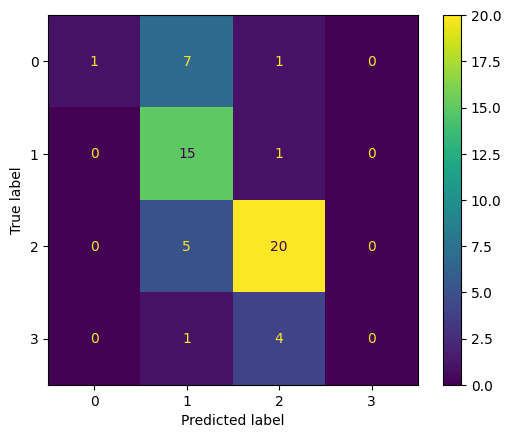

In [63]:
plot_confusion_matrix(y_test, \
                      cbc_gpu_optuna.predict(tf_idf_test))

In [64]:
metrics = get_metrics(y_test, 
                      cbc_gpu_optuna.predict(tf_idf_test),
                      name='Catboost_optuna', metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45
LogisticRegression,0.57,0.47,0.43,0.62
RandomForesClassifier,0.53,0.41,0.37,0.58
LightGBM,0.38,0.41,0.39,0.56
Catboost_baseline,0.72,0.56,0.57,0.69
Catboost_optuna,0.58,0.46,0.42,0.65


In [65]:
check_overfitting(cbc_gpu_optuna, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.879
f1_score test: 0.417
delta = 52.6 %


## BERT

In [66]:
from bert_dataset import CustomDataset
from bert_classifier import BertClassifier

In [67]:
classifier = BertClassifier(
        model_path='bert-large-uncased',
        tokenizer_path='bert-large-uncased',
        n_classes=y_train.nunique(),
        epochs=2,
        model_save_path='content/bert_large.pt'
);

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [68]:
classifier.preparation(
        X_train=list(X_train),
        y_train=list(y_train),
        X_valid=list(X_test),
        y_valid=list(y_test)
    )

In [69]:
flag = 0
if flag:
    classifier.train()
else:
    classifier.model = torch.load('content/bert_large.pt')

In [70]:
flag = 0
if flag:
    y_pred_bert = [classifier.predict(t) for t in X_test]
    with open('y_pred_bert.pkl', 'wb') as file:
        pickle.dump(y_pred_bert, file)
else:
    with open('y_pred_bert.pkl', 'rb') as file:
        y_pred_bert = pickle.load(file)

In [71]:
print(classification_report(y_test, y_pred_bert))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        16
           2       0.45      1.00      0.62        25
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.11      0.25      0.16        55
weighted avg       0.21      0.45      0.28        55



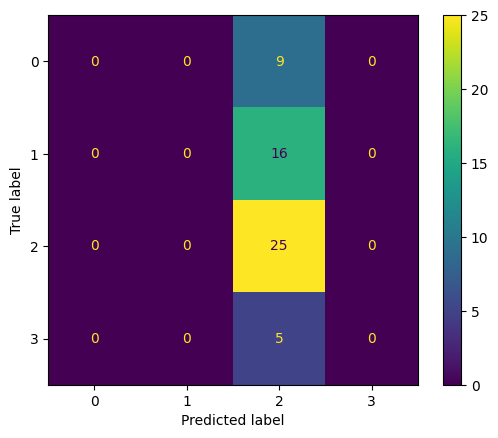

In [73]:
plot_confusion_matrix(y_test, y_pred_bert)

In [74]:
metrics = get_metrics(y_test, y_pred_bert, 'Bert',  metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45
LogisticRegression,0.57,0.47,0.43,0.62
RandomForesClassifier,0.53,0.41,0.37,0.58
LightGBM,0.38,0.41,0.39,0.56
Catboost_baseline,0.72,0.56,0.57,0.69
Catboost_optuna,0.58,0.46,0.42,0.65
Bert,0.11,0.25,0.16,0.45


## Анализ результатов моделирования

### Полученные метрики

In [75]:
metrics.sort_values(by='f1_score', ascending=False)

,precision,recall,f1_score,accuracy
Catboost_baseline,0.72,0.56,0.57,0.69
LogisticRegression,0.57,0.47,0.43,0.62
Catboost_optuna,0.58,0.46,0.42,0.65
LightGBM,0.38,0.41,0.39,0.56
RandomForesClassifier,0.53,0.41,0.37,0.58
dummy_model,0.11,0.25,0.16,0.45
Bert,0.11,0.25,0.16,0.45


### Матрицы ошибок

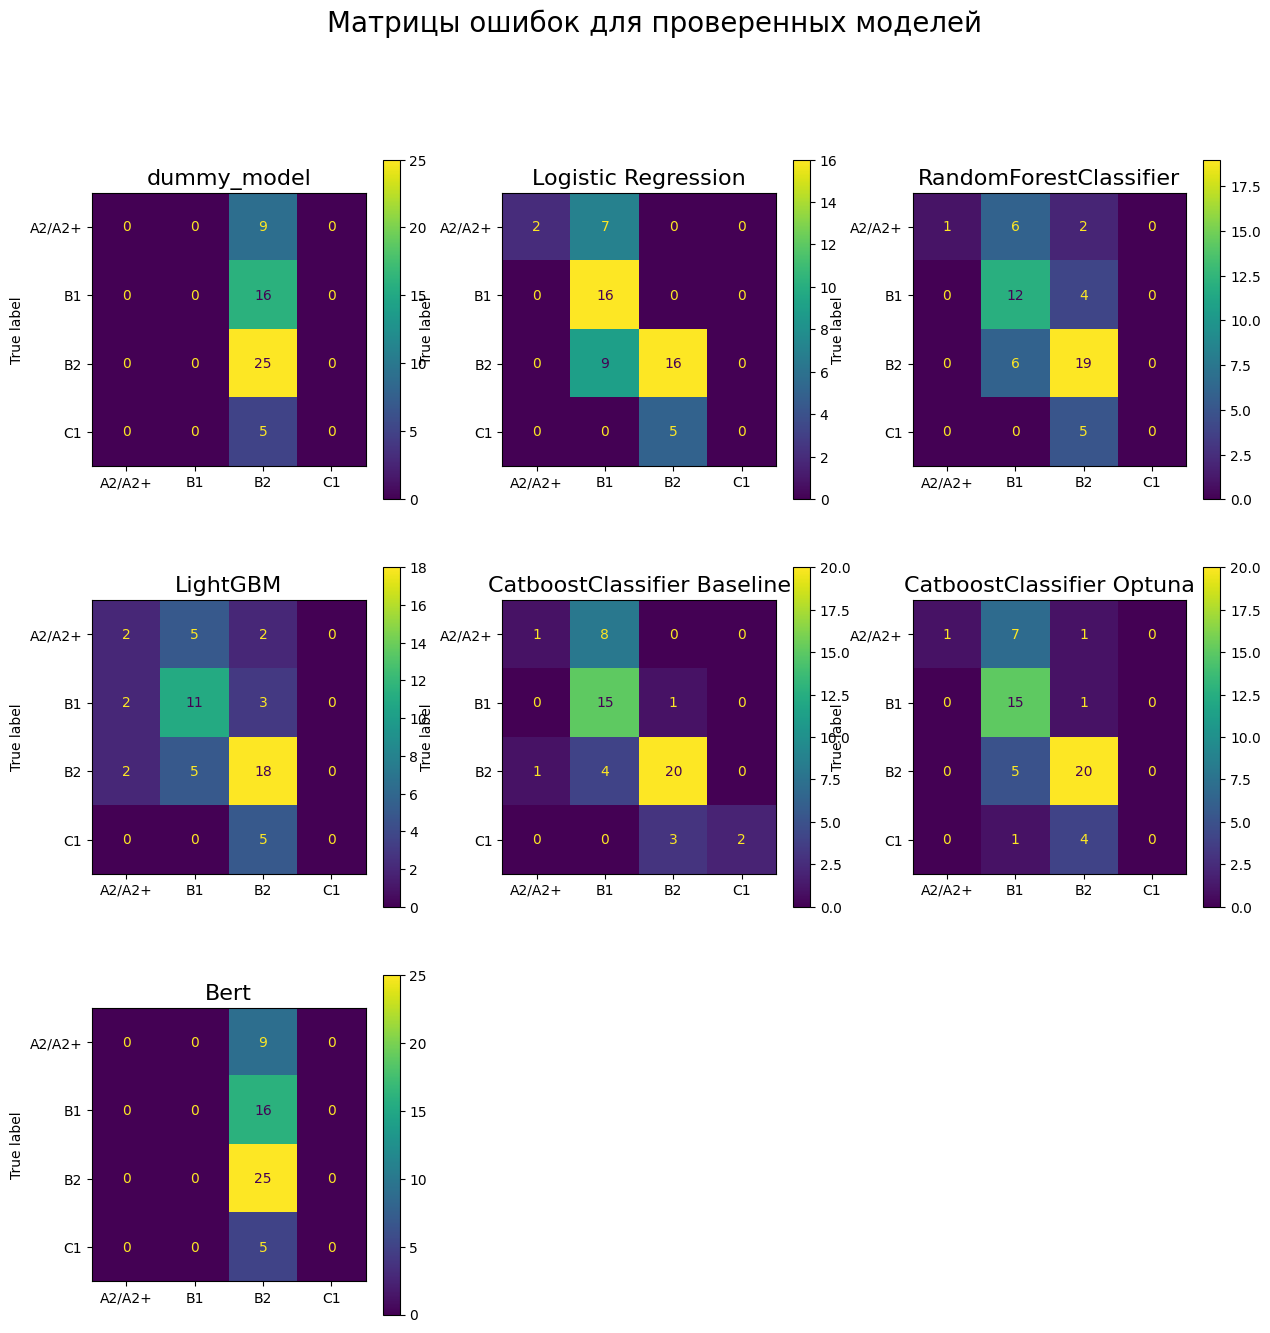

In [76]:
models = {'dummy_model': 'dummy_model', 
          'Logistic Regression': grid_lr.best_estimator_,
           'RandomForestClassifier' : grid_rfc.best_estimator_,
             'LightGBM': grid_lgb.best_estimator_, 
             'CatboostClassifier Baseline': cbc_gpu_baseline, 
             'CatboostClassifier Optuna': cbc_gpu_optuna, 
             'Bert': classifier}
n_cols = 3
n_rows = len(models) // n_cols  + 1
counter = 1
f= plt.figure(figsize=(15,5 * n_rows))
f.suptitle('Матрицы ошибок для проверенных моделей', fontsize=20)
for key, value in models.items():
    ax = plt.subplot(n_rows, n_cols, counter)
    if key == 'dummy_model':
        ConfusionMatrixDisplay(confusion_matrix(y_test,
                                                 2 * np.ones(len(y_test))),
                                                 display_labels=english_levels).plot(ax=ax)
    elif key=='Bert':
        ConfusionMatrixDisplay(confusion_matrix(y_test,
                                                 y_pred_bert),
                                                 display_labels=english_levels).plot(ax=ax)
    else:
        ConfusionMatrixDisplay(confusion_matrix(y_test, 
                                                value.predict(tf_idf_test)),
                                                 display_labels=english_levels).plot(ax=ax)
    plt.title(key, fontsize=16)
    plt.xlabel('')
    counter += 1 

### Проверка на overfitting

In [77]:
models = {'Logistic Regression': grid_lr.best_estimator_,
           'RandomForestClassifier' : grid_rfc.best_estimator_,
             'LightGBM': grid_lgb.best_estimator_, 
             'CatboostClassifier Baseline': cbc_gpu_baseline, 
             'CatboostClassifier Optuna': cbc_gpu_optuna}
overfitting = {}
for model_name, model in models.items():
    overfitting[model_name] = check_overfitting(model, tf_idf_train, y_train,
                                                 tf_idf_test, y_test, 
                                                 f1_score, return_delta=True)
overfitting = pd.DataFrame(data=overfitting.values(), 
                           index=overfitting.keys(), columns=['overfitting'])
overfitting.sort_values(by='overfitting', ascending=False)

,overfitting
RandomForestClassifier,62.45
LightGBM,61.20
Logistic Regression,54.02
CatboostClassifier Optuna,52.61
CatboostClassifier Baseline,42.90


### Вывод по анализу примененных моделей

1. Лучшей моделью оказался `CatboostClassifier` без дополнительной настройки гиперпараметров. Удалось достичь показателей на тестовой выборке
<br>$$ accuracy = 0.69, f1\_score=0.57 $$
2. Также весьма хорошие результаты показала `Logistic Regression`. Не совершив ни одной ошибки сильнее, чем на 1 уровень знания языка.
3. Сложнее всего моделям давалось определение фильмов уровня `A1/A1+`. Так как в датасете таких было меньше всего. Присутствовал дисбаланс классов.
4. Объем данных (размеченных субтитров) недостаточен. Из-за этого модели сильно переобучались. 
5. Нейросеть `Bert` (вероятно из-за недостаточного объема данных) предсказала наиболее популярных класс для всех тестовых данных - аналогично `dummy-model`

## Дополнительные данные